In [1]:
# standard imports
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import time as time
#import json
import pickle

# 3rd party packages
import qiskit as qk
import qiskit.providers.aer.noise as noise
import networkx as nx
import tenpy as tp

## custom things
from networks.networks import IsoMPS
from networks.isonetwork import QKParamCircuit
import circuits.basic_circuits as circuits

## HoloPy demo: spin-chain

XXZ: $$H_\text{XXZ}=\sum_{i}J\left(\sigma^x_{i}\sigma^x_{i+1}+\sigma^y_{i}\sigma^y_{i+1} + \Delta \sigma^z_i\sigma^z_{i+1}\right)+h_z\sigma^z_i$$

Ising: $$H_\text{TFIM}=\sum_i -J\sigma^x_i\sigma^x_{i+1}-h\sigma^x_{i}$$

In [67]:
# ansatz parameters
nb = 1 # number of bond-qubits 
L = 1 # number of unit cells
l_uc = 1 # number of sites in unit cell

In [68]:
## Setup IsoMPS ##
# initialize registers
preg = qk.QuantumRegister(1,'p') # physical qubits
breg = qk.QuantumRegister(nb,'b') # bond qubits
creg = qk.ClassicalRegister(L*l_uc+nb,'m') # classical register to hold measurement outcomes

## Initialize parameterized circuits
# bond-prep circuit (sets left-boundary vector of MPS)
bond_prep_circ = QKParamCircuit(qk.QuantumCircuit(breg),[])
circs = []#[bond_prep_circ]

# circuits that generate tensors
param_names= [] # list of circuit parameters
for j in range(l_uc):
    # circuit to initialize state (start in state 101010101...)
    init_circ = qk.QuantumCircuit(preg)
    init_circ.h(preg)
    #if j%2==0: init_circ.x(preg)
    
    circ_tmp,params_tmp = circuits.star_circ(preg,
                                             breg,
                                             label='[c{}]'.format(j),
                                             circ_type='xxz',
                                             init_circ=init_circ)   
    circs+=[circ_tmp]
    param_names+=params_tmp

# setup circuit-generated isoMPS
psi = IsoMPS(preg,breg,circs,L=L)

{Parameter([c0]0): 2.081293671747685, Parameter([c0]1): 9.134662543718534, Parameter([c0]2): 3.0027250208671123}


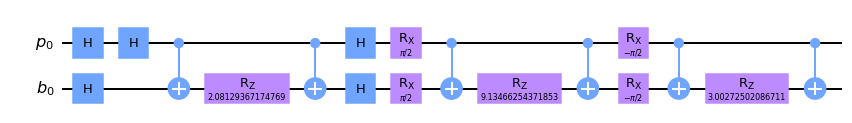

In [69]:
## Example (resolve parameters => random values and print circuit)
# pick some random parameter values
param_vals = [4*np.pi*np.random.rand() for j in range(len(param_names))]
param_dict = dict(zip(param_names,param_vals))
psi.construct_circuit(param_dict,include_measurements=False)
print(param_dict)
psi.circ.draw('mpl')

## 1. Compute energy by exporting to tenpy

In [70]:
## Functions to create tenpy models
def ising_impo(J, h):
    site = tp.networks.site.SpinHalfSite(conserve=None)
    #Id, Sp, Sm, Sz = site.Id, site.Sp, site.Sm, 2*site.Sz
    #Sx = Sp + Sm
    Id, Sx, Sz = site.Id, site.Sigmax, site.Sigmaz
    W = [[Id,Sx,-h*Sz], 
         [None,None,-J*Sx], 
         [None,None,Id]]
    H = tp.networks.mpo.MPO.from_grids([site], [W], bc='infinite', IdL=0, IdR=-1)
    return H

def xxz_impo(Delta):
    """
    Doesn't work! (leg-charge error?)
    """
    site = tp.networks.site.SpinHalfSite(conserve=None)
    Id, Sp, Sm, Sz = site.Id, site.Sp, site.Sm, site.Sigmaz
    Sx = Sp + Sm
    W = [[Id,Sp,Sm,Sz], 
         [None,None,None,1/2*Sm],
         [None,None,None,1/2*Sp],
         [None,None,None,Delta*Sz],
         [None,None,None,Id]]
    H = tp.networks.mpo.MPO.from_grids([site], [W], bc='infinite', IdL=0, IdR=-1)
    return H

def xxz_mpo(J=1.0, Delta=1.0, hz=0.0, N=1, bc='infinite'):
    site = tp.networks.site.SpinHalfSite(None)
    Id, Sp, Sm, Sz = site.Id, site.Sp, site.Sm, 2*site.Sz
    W_bulk = [[Id, Sp, Sm, Sz, -hz * Sz],
              [None, None, None, None, 0.5 * J * Sm],
              [None, None, None, None, 0.5 * J * Sp],
              [None, None, None, None, J * Delta * Sz],
              [None, None, None, None, Id]]
    #W_first = [W_bulk[0]]  # first row
    #W_last = [[row[-1]] for row in W_bulk]  # last column
    #Ws = [W_first] + [W_bulk]*(N - 2) + [W_last]
    #H = tp.networks.mpo.MPO.from_grids([site]*N, Ws, bc, IdL=0, IdR=-1) # (probably leave the IdL,IdR)
    H = tp.networks.mpo.MPO.from_grids([site], [W_bulk], bc, IdL=0, IdR=-1) # (probably leave the IdL,IdR)
    return H

test = xxz_mpo()

# energy calculator
def energy_tp(param_vals,*args):
    """
    function to calculate energy using MPO/MPS contraction in tenpy
    inputs:
        - param_vals = dict {parameter:value}
        - *args, 
            args[0] should be psi: state as IsoMPS
            args[1] should be H_mpo: Hamiltonian as MPO
        (input made this way to be compatible w/ scipy.optimize)
    outputs:
        - float, <psi|H|psi> computed w/ tenpy
    """
    # parse inputs
    psi=args[0] # state as isoMPS    
    H_mpo = args[1] # Hamiltonian as tenpy MPO
    param_dict = dict(zip(param_names,param_vals))
    
    # convert state from holoPy isoMPS to tenpy MPS
    psi_tp = psi.to_tenpy(param_dict,L=np.inf)
    
    # compute energy
    E = (H_mpo.expectation_value(psi_tp)).real
    return E

## Define the Model

In [ ]:
## define model ##
J = -1.0
Delta = 1.3
hz = 0.0

### classically optimize the variational circuit using tenpy

In [138]:
H_mpo = xxz_mpo(J=J,hz=hz,Delta=Delta,N=1)#ising_impo(J=1,h=1) # Hamiltonian as tenpy MPO
# file saving info
subdir = 'test_data' # subfolder to hold data
filename = 'xxzjobs_Delta1p3.dat'.format(np.round(Delta)) # file name for saved data


# optimize ansatz using tenpy
x0 = 0.03*np.random.randn(len(param_names)) # starting point for parameters
t0 = time.time()
opt_result = minimize(energy_tp, # function to minimize
                      x0, # starting point for parameters 
                      args=(psi,H_mpo), # must take form (isoMPS,tenpy MPO)
                      method='BFGS'
                     )
tf = time.time()
# set parameters to previously optimized values
opt_vals = opt_result.x
opt_params = dict(zip(param_names,opt_vals))

print('Optimization done, elapsed time: {}'.format(tf-t0))
print('Optimized energy = {}'.format(opt_result.fun))

Optimization done, elapsed time: 5.999658107757568
Optimized energy = -1.2999999999998615


## 2. Qiskit simulations
Now, compute the energy for the optimized parameter values in qiskit

In [162]:
## Specify hyperparameters ##
L=10 # length of chain to simulate
shots = 1000 # number of shots for each measurement

# list of Pauli strings to measure
# example format for L = 3, l_uc = 4: [['xxxy'],['zzzz'],['yzxz']]
measurement_strings = [['x']*L,
                       ['y']*L,
                       ['z']*L] 


# Create meta-data
model_data = {'type':'xxz',
              'J':J,
              'Delta':Delta,
              'hz':hz,
              'L':L,
              'shots':shots,
             }
vqe_data = {'architecture':'su4_star',
                'nb':nb,
                'params':opt_params}

In [163]:
## Create jobs ##
# loop through measurement strings, and create list of jobs to run
jobs = []
for m in measurement_strings:
    psi_curr = IsoMPS(preg,breg,circs,bases=m,L=L)
    circ_curr = psi_curr.construct_circuit(opt_params)
    jobs += [{'name':'xxz_xxzstar_hz{}'.format(hz)+'_basis_'+m[0],
              'isoMPS':psi_curr,
              'vqe_data':vqe_data,
              'qiskit_circuit':circ_curr,
              'qasm':circ_curr.qasm(),
              'model':model_data,
              'basis':m,
              'shots':shots,
              'job_id':None, # job-id when submitted to honeywell
              'qiskit_results':None, # qiskit simultor results
              'results':None # Honeywell results
              }]

# save jobs dict to pickle file
file = open(subdir+'/' + filename, 'wb') 
pickle.dump(jobs, file)                      
file.close() 

### Qiskit Simulation

In [164]:
## Define Noise Model ##
# errors (simulation)
perr_1q = 0.000 # 1-qubit gate error
perr_2q = 0.00 # 2-qubit gate error
# depolarizaing errors
depol_1q = noise.depolarizing_error(perr_1q, 1)
depol_2q = noise.depolarizing_error(perr_2q, 2)
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(depol_1q, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(depol_2q, ['cx','cz'])

In [165]:
## Run Jobs (qiskit version) ##
# load job files
file = open(subdir+'/' + filename, 'rb') 
jobs = pickle.load(file)
file.close() 

# setup qiskit simulator
simulator = qk.Aer.get_backend('qasm_simulator')
for job in jobs:
    shots = job['shots']
    job['qiskit_results'] = qk.execute(job['qiskit_circuit'], 
                               simulator, 
                               shots=shots,
                               noise_model=noise_model).result()

# save jobs dict to pickle file
file = open(subdir+'/' + filename, 'wb') 
pickle.dump(jobs, file)                      
file.close()     

# Post-processing

First define some functions to extract one- and two- point correlators from counts dictionary

### (Note that, this will have to be adjusted depending on the structure of registers in the circuit)

In [167]:
def counts_to_correlators(counts,shots):
    """
    converts qiskit-style counts result 
    to NxN numpy array of 2-point correlatrs
    w/ N = # of sites in isoMPS = L*l_uc
    """
    # number of sites (compute from input dictionary shape)
    N = len(list(counts.keys())[0].split(" ")) 
    C = np.zeros((N,N))
    # loop over each measurement outcome
    for k in counts.keys(): 
        split_list = k.split(" ")[::-1] # split bits from each register
        # note that qiskit typically orders in reverse order 
        # NOTE: WILL NEED TO REVISIT CREG ORDERING IF WE HAVE OTHER CREGs
        
        # compute up all pairs of correlators
        for x in range(N):
            for y in range(x+1,N): # use symmetry C[x,y]=C[y,x] to only compute 1/2 of entries
               C[x,y] += counts[k] * (2.0*(split_list[x]==split_list[y])-1.0)
    C /= shots # normalize
    C += C.T + np.eye(N) # we've constructed only the upper-right triangular part
    return C

def counts_to_mean(counts,shots):
    """
    converts qiskit-type counts result to 
    one point correlator (mean spin component)
    on each site
    """
    N = len(list(counts.keys())[0].split(" "))
    m = np.zeros(N)
    for k in counts.keys(): 
        split_array = np.array(k.split(" ")[::-1]) # split bits from each register
        m += 2.0*(split_array=='1')-1.0
    m /= shots
    return m

### Example: Compute E from correlators

In [168]:
## Post-process results ##
# load job files
file = open(subdir+'/' + filename, 'rb') 
jobs = pickle.load(file)
file.close() 

# compute two-point correlators from counts
Cs = {} # dictionary of 2-point correlators
ms = {} # dictionary of 1-spin correlators ('magnetizations')
for job in jobs:
    counts = job['qiskit_results'].get_counts()
    key = job['basis'][0] #'x','y',or'z' (assumes measurements are same type on each bond)
    Cs[key] = counts_to_correlators(counts,job['shots'])
    ms[key] = counts_to_mean(counts,job['shots'])
N = len(list(counts.keys())[0].split(" "))


# estimate <H>
burn_in = 4 # number of sites to "burn in" MPS channel before measuring
sites = np.arange(burn_in,L*l_uc-1) # remaining sites
E = 0
for j in sites:
    E += job['model']['J']*(Cs['x'][j,j+1]+Cs['y'][j,j+1])
    E += job['model']['J'] * job['model']['Delta']*Cs['z'][j,j+1]
E += job['model']['hz'] * np.sum(ms['z'])
E = E/sites.size # convert to energy density
print('Energy density - estimate = {}'.format(E))

# save jobs dict to pickle file
#file = open(subdir+'/' + filename, 'wb') 
#pickle.dump(jobs, file)                      
#file.close()  

['x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x']
['y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y']
['z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z', 'z']
Energy density - estimate = -1.3208


In [169]:
## Plot results ##
